# Deteccao de Celulas Sanguineas - Dataset BCCD

## Projeto de Processamento de Imagens

**Objetivo:** Desenvolver um modelo de deteccao de objetos para identificar e classificar celulas sanguineas em imagens de laminas de sangue, utilizando apenas tecnicas de processamento de imagem tradicionais, sem o uso de aprendizado de maquina ou redes neurais.

**Dataset:** BCCD (Blood Cell Count Detection) - https://public.roboflow.com/object-detection/bccd

**Tipos de celulas a detectar:**
- **RBC (Red Blood Cells):** Eritrocitos/Hemacias - celulas circulares vermelhas
- **WBC (White Blood Cells):** Leucocitos - celulas maiores com nucleo escuro/roxo
- **Platelets:** Plaquetas - fragmentos celulares muito pequenos

**Tecnicas tradicionais utilizadas:**
1. Conversao RGB para escala de cinza
2. Realce de contraste (stretch de histograma)
3. Filtro Gaussiano (suavizacao)
4. Filtro de Sobel (deteccao de bordas)
5. Transformada de Hough Circular (CHT)
6. Operacoes morfologicas (erosao, dilatacao, abertura, fechamento)
7. Top-hat (normalizacao de fundo)
8. Limiarizacao (thresholding)
9. Analise de componentes conexas

**Autores:** Paulo Hercilio Araujo Santana / Alan Jonatas de Oliveira Gama

---
## 1. Importacao de Bibliotecas e Configuracoes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.measure import label, regionprops
import os
import glob
import xml.etree.ElementTree as ET

# Configuracao de visualizacao
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


---
## 2. Funcoes Auxiliares de Processamento de Imagem

Todas as funcoes abaixo sao implementacoes de tecnicas tradicionais de processamento de imagem, sem uso de aprendizado de maquina.

In [2]:
# ============================================================
# 2.1 CONVERSAO PARA ESCALA DE CINZA
# ============================================================

def rgb2gray(img):
    """
    Converte imagem RGB para escala de cinza usando a formula de luminancia.
    Y = 0.2989*R + 0.5870*G + 0.1140*B
    """
    if len(img.shape) == 3:
        return np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    return img

print("Funcao rgb2gray definida.")

Funcao rgb2gray definida.


In [3]:
# ============================================================
# 2.2 CONVOLUCAO 2D
# ============================================================

def convolve2d(image, kernel):
    """
    Convolucao 2D otimizada para kernels pequenos usando numpy.
    Usada para aplicar filtros espaciais na imagem.
    """
    k_h, k_w = kernel.shape
    h, w = image.shape
    
    # Padding da imagem (borda)
    pad_h = k_h // 2
    pad_w = k_w // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    
    output = np.zeros_like(image, dtype=np.float64)
    
    # Flip do kernel (definicao de convolucao)
    kernel = np.flipud(np.fliplr(kernel))
    
    # Iteracao sobre o kernel (mais rapido que iterar sobre a imagem em Python)
    for i in range(k_h):
        for j in range(k_w):
            output += padded_image[i:h+i, j:w+j] * kernel[i, j]
            
    return output

print("Funcao convolve2d definida.")

Funcao convolve2d definida.


In [4]:
# ============================================================
# 2.3 FILTRO GAUSSIANO
# ============================================================

def gaussian_kernel(size, sigma=1.0):
    """
    Cria um kernel Gaussiano para suavizacao de imagem.
    Reduz ruido antes da deteccao de bordas.
    """
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

def gaussian_blur(image, size=5, sigma=1.0):
    """
    Aplica filtro Gaussiano para suavizar a imagem.
    """
    kernel = gaussian_kernel(size, sigma)
    return convolve2d(image, kernel)

print("Funcoes gaussian_kernel e gaussian_blur definidas.")

Funcoes gaussian_kernel e gaussian_blur definidas.


In [5]:
# ============================================================
# 2.4 DETECCAO DE BORDAS (SOBEL)
# ============================================================

def sobel_edges(image, blur_first=True):
    """
    Detecta bordas usando filtros de Sobel.
    Calcula magnitude do gradiente: G = sqrt(Gx^2 + Gy^2)
    """
    # Suavizacao Gaussiana opcional (reduz ruido)
    if blur_first:
        g_kernel = gaussian_kernel(5, sigma=1.0)
        image = convolve2d(image, g_kernel)
    
    # Filtros de Sobel
    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    ix = convolve2d(image, Gx)
    iy = convolve2d(image, Gy)
    
    magnitude = np.sqrt(ix**2 + iy**2)
    
    # Normalizacao min-max
    if magnitude.max() > 0:
        magnitude = magnitude / magnitude.max() * 255
    
    return magnitude

print("Funcao sobel_edges definida.")

Funcao sobel_edges definida.


In [6]:
# ============================================================
# 2.5 OPERACOES MORFOLOGICAS
# ============================================================

def erosion_binary(img, SE):
    """
    Erosao binaria: AND logico entre vizinhancas.
    Remove pixels isolados e reduz objetos.
    Suporta SE de qualquer tamanho (deve ser impar).
    """
    SE_h, SE_w = SE.shape
    pad_h, pad_w = SE_h // 2, SE_w // 2
    
    # Padding com zeros (para erosao, pixels fora sao 0)
    img_padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    
    H, W = img.shape
    result = np.ones((H, W), dtype=np.uint8)
    
    # Para cada pixel da imagem
    for i in range(H):
        for j in range(W):
            # Extrai a vizinhanca
            neighborhood = img_padded[i:i+SE_h, j:j+SE_w]
            # Erosao: pixel = 1 se todos os vizinhos sob SE=1 forem 1
            result[i, j] = np.all(neighborhood[SE == 1] == 1)
    
    return result

def dilation_binary(img, SE):
    """
    Dilatacao binaria: OR logico entre vizinhancas.
    Preenche buracos e expande objetos.
    Suporta SE de qualquer tamanho (deve ser impar).
    """
    SE_h, SE_w = SE.shape
    pad_h, pad_w = SE_h // 2, SE_w // 2
    
    # Padding com zeros (para dilatacao, pixels fora sao 0)
    img_padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    
    H, W = img.shape
    result = np.zeros((H, W), dtype=np.uint8)
    
    # Para cada pixel da imagem
    for i in range(H):
        for j in range(W):
            # Extrai a vizinhanca
            neighborhood = img_padded[i:i+SE_h, j:j+SE_w]
            # Dilatacao: pixel = 1 se algum vizinho sob SE=1 for 1
            result[i, j] = np.any(neighborhood[SE == 1] == 1)
    
    return result

def opening_binary(img, SE):
    """
    Abertura binaria: Erosao seguida de Dilatacao.
    Remove ruido (objetos pequenos).
    """
    return dilation_binary(erosion_binary(img, SE), SE)

def closing_binary(img, SE):
    """
    Fechamento binario: Dilatacao seguida de Erosao.
    Preenche buracos pequenos.
    """
    return erosion_binary(dilation_binary(img, SE), SE)

print("Funcoes morfologicas binarias definidas.")

Funcoes morfologicas binarias definidas.


In [7]:
# ============================================================
# 2.6 MORFOLOGIA EM ESCALA DE CINZA
# ============================================================

def erosion_gray(img, SE_size=3):
    """
    Erosao em escala de cinza: minimo local.
    """
    from scipy.ndimage import minimum_filter
    return minimum_filter(img, size=SE_size)

def dilation_gray(img, SE_size=3):
    """
    Dilatacao em escala de cinza: maximo local.
    """
    from scipy.ndimage import maximum_filter
    return maximum_filter(img, size=SE_size)

def opening_gray(img, SE_size=3):
    """
    Abertura em escala de cinza.
    """
    return dilation_gray(erosion_gray(img, SE_size), SE_size)

def closing_gray(img, SE_size=3):
    """
    Fechamento em escala de cinza.
    """
    return erosion_gray(dilation_gray(img, SE_size), SE_size)

def tophat(img, SE_size=11):
    """
    Top-hat: Imagem - Abertura.
    Destaca regioes claras em fundo nao-uniforme.
    """
    opened = opening_gray(img, SE_size)
    result = img.astype(np.float64) - opened.astype(np.float64)
    result[result < 0] = 0
    return result

def bottomhat(img, SE_size=11):
    """
    Bottom-hat: Fechamento - Imagem.
    Destaca regioes escuras em fundo nao-uniforme.
    """
    closed = closing_gray(img, SE_size)
    result = closed.astype(np.float64) - img.astype(np.float64)
    result[result < 0] = 0
    return result

print("Funcoes morfologicas em escala de cinza definidas.")

Funcoes morfologicas em escala de cinza definidas.


In [8]:
# ============================================================
# 2.7 REALCE DE CONTRASTE
# ============================================================

def histogram_stretch(img, pmin=2, pmax=98):
    """
    Stretch de histograma usando percentis.
    Melhora o contraste da imagem.
    """
    img = img.astype(np.float64)
    vmin = np.percentile(img, pmin)
    vmax = np.percentile(img, pmax)
    
    img_stretched = (img - vmin) / (vmax - vmin) * 255
    img_stretched = np.clip(img_stretched, 0, 255)
    
    return img_stretched.astype(np.uint8)

print("Funcao histogram_stretch definida.")

Funcao histogram_stretch definida.


In [9]:
# ============================================================
# 2.8 TRANSFORMADA DE HOUGH CIRCULAR (CHT)
# ============================================================

def detect_circles_hough(gray_img, r_min, r_max, threshold_edge=40, threshold_acc=50, min_dist=35):
    """
    Detecta circulos usando a Transformada de Hough Circular.
    
    Parametros:
    - gray_img: Imagem em escala de cinza
    - r_min, r_max: Intervalo de raios a detectar
    - threshold_edge: Limiar para deteccao de bordas
    - threshold_acc: Minimo de votos no acumulador
    - min_dist: Distancia minima entre centros detectados
    
    Retorna:
    - Lista de circulos detectados: [(x, y, r, votos), ...]
    """
    # Deteccao de bordas
    edges = sobel_edges(gray_img, blur_first=True)
    
    # Pontos de borda
    edge_points = np.argwhere(edges > threshold_edge)  # (y, x)
    
    if len(edge_points) == 0:
        return []
    
    H, W = gray_img.shape
    radii = np.arange(r_min, r_max + 1)
    acc = np.zeros((H, W, len(radii)), dtype=np.uint64)
    
    # Pre-calculo dos offsets de votacao
    thetas = np.deg2rad(np.arange(0, 360, 5))  # Passo de 5 graus para otimizacao
    cos_thetas = np.cos(thetas)
    sin_thetas = np.sin(thetas)
    
    circle_offsets = {}
    for r in radii:
        dx = np.round(r * cos_thetas).astype(int)
        dy = np.round(r * sin_thetas).astype(int)
        circle_offsets[r] = (dx, dy)
    
    # Votacao no acumulador
    for y_edge, x_edge in edge_points:
        for r_idx, r in enumerate(radii):
            dx, dy = circle_offsets[r]
            
            # Possiveis centros
            a_idx = x_edge - dx
            b_idx = y_edge - dy
            
            # Verifica limites
            valid_mask = (a_idx >= 0) & (a_idx < W) & (b_idx >= 0) & (b_idx < H)
            a_valid = a_idx[valid_mask]
            b_valid = b_idx[valid_mask]
            
            acc[b_valid, a_valid, r_idx] += 1
    
    # Encontra picos no acumulador
    candidates = np.argwhere(acc >= threshold_acc)
    
    circles = []
    for y, x, r_i in candidates:
        vote_val = acc[y, x, r_i]
        radius = radii[r_i]
        circles.append((x, y, radius, vote_val))
    
    # Ordena por numero de votos (maior primeiro)
    circles.sort(key=lambda c: c[3], reverse=True)
    
    # Remove circulos redundantes (NMS simplificado)
    detected_circles = []
    for c in circles:
        x, y, r, v = c
        is_new = True
        for dc in detected_circles:
            dx, dy, dr, dv = dc
            dist = np.sqrt((x - dx)**2 + (y - dy)**2)
            if dist < min_dist:
                is_new = False
                break
        if is_new:
            detected_circles.append(c)
    
    return detected_circles

print("Funcao detect_circles_hough definida.")

Funcao detect_circles_hough definida.


In [10]:
# ============================================================
# 2.9 LIMIARIZACAO (THRESHOLDING)
# ============================================================

def threshold_otsu(img):
    """
    Calcula o limiar otimo usando o metodo de Otsu.
    Maximiza a variancia entre classes.
    """
    hist, bins = np.histogram(img.flatten(), bins=256, range=(0, 256))
    hist = hist.astype(np.float64)
    hist /= hist.sum()
    
    best_thresh = 0
    best_var = 0
    
    for t in range(1, 256):
        w0 = hist[:t].sum()
        w1 = hist[t:].sum()
        
        if w0 == 0 or w1 == 0:
            continue
        
        mu0 = np.sum(np.arange(t) * hist[:t]) / w0
        mu1 = np.sum(np.arange(t, 256) * hist[t:]) / w1
        
        var_between = w0 * w1 * (mu0 - mu1) ** 2
        
        if var_between > best_var:
            best_var = var_between
            best_thresh = t
    
    return best_thresh

def binarize(img, threshold=None):
    """
    Binariza a imagem usando o limiar especificado ou Otsu.
    """
    if threshold is None:
        threshold = threshold_otsu(img)
    
    binary = np.zeros_like(img, dtype=np.uint8)
    binary[img > threshold] = 1
    return binary, threshold

print("Funcoes threshold_otsu e binarize definidas.")

Funcoes threshold_otsu e binarize definidas.


In [11]:
# ============================================================
# 2.10 FUNCOES UTILITARIAS
# ============================================================

def load_bccd_images(folder='bccd_images/train', max_images=None):
    """
    Carrega imagens do dataset BCCD.
    """
    pattern = os.path.join(folder, '*.jpg')
    image_files = sorted(glob.glob(pattern))
    
    if max_images:
        image_files = image_files[:max_images]
    
    images = []
    for f in image_files:
        img = io.imread(f)
        images.append((f, img))
    
    return images

def parse_voc_xml(xml_path):
    """
    Parse arquivo XML no formato Pascal VOC.
    Retorna lista de objetos com nome e bounding box.
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    objects = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        objects.append({
            'name': name,
            'bbox': (xmin, ymin, xmax, ymax)
        })
    
    return objects

def draw_circles(img, circles, color=(255, 0, 0), thickness=2):
    """
    Desenha circulos na imagem.
    """
    result = img.copy()
    if len(result.shape) == 2:
        result = np.stack([result, result, result], axis=-1)
    
    for (x, y, r, _) in circles:
        # Desenha circulo manualmente
        for angle in np.linspace(0, 2*np.pi, 100):
            px = int(x + r * np.cos(angle))
            py = int(y + r * np.sin(angle))
            if 0 <= px < result.shape[1] and 0 <= py < result.shape[0]:
                for t in range(-thickness//2, thickness//2 + 1):
                    for s in range(-thickness//2, thickness//2 + 1):
                        if 0 <= py+t < result.shape[0] and 0 <= px+s < result.shape[1]:
                            result[py+t, px+s] = color
    
    return result

def draw_rectangles(img, rectangles, color=(0, 255, 0), thickness=2):
    """
    Desenha retangulos na imagem.
    rectangles: lista de (xmin, ymin, xmax, ymax)
    """
    result = img.copy()
    if len(result.shape) == 2:
        result = np.stack([result, result, result], axis=-1)
    
    for (xmin, ymin, xmax, ymax) in rectangles:
        # Desenha retangulo
        for t in range(thickness):
            # Linhas horizontais
            if ymin+t < result.shape[0]:
                result[ymin+t, max(0,xmin):min(result.shape[1],xmax)] = color
            if ymax-t-1 >= 0 and ymax-t-1 < result.shape[0]:
                result[ymax-t-1, max(0,xmin):min(result.shape[1],xmax)] = color
            # Linhas verticais
            if xmin+t < result.shape[1]:
                result[max(0,ymin):min(result.shape[0],ymax), xmin+t] = color
            if xmax-t-1 >= 0 and xmax-t-1 < result.shape[1]:
                result[max(0,ymin):min(result.shape[0],ymax), xmax-t-1] = color
    
    return result

print("Funcoes utilitarias definidas.")

Funcoes utilitarias definidas.


---
## 3. Carregamento e Exploracao dos Dados

Carregadas 6 imagens.


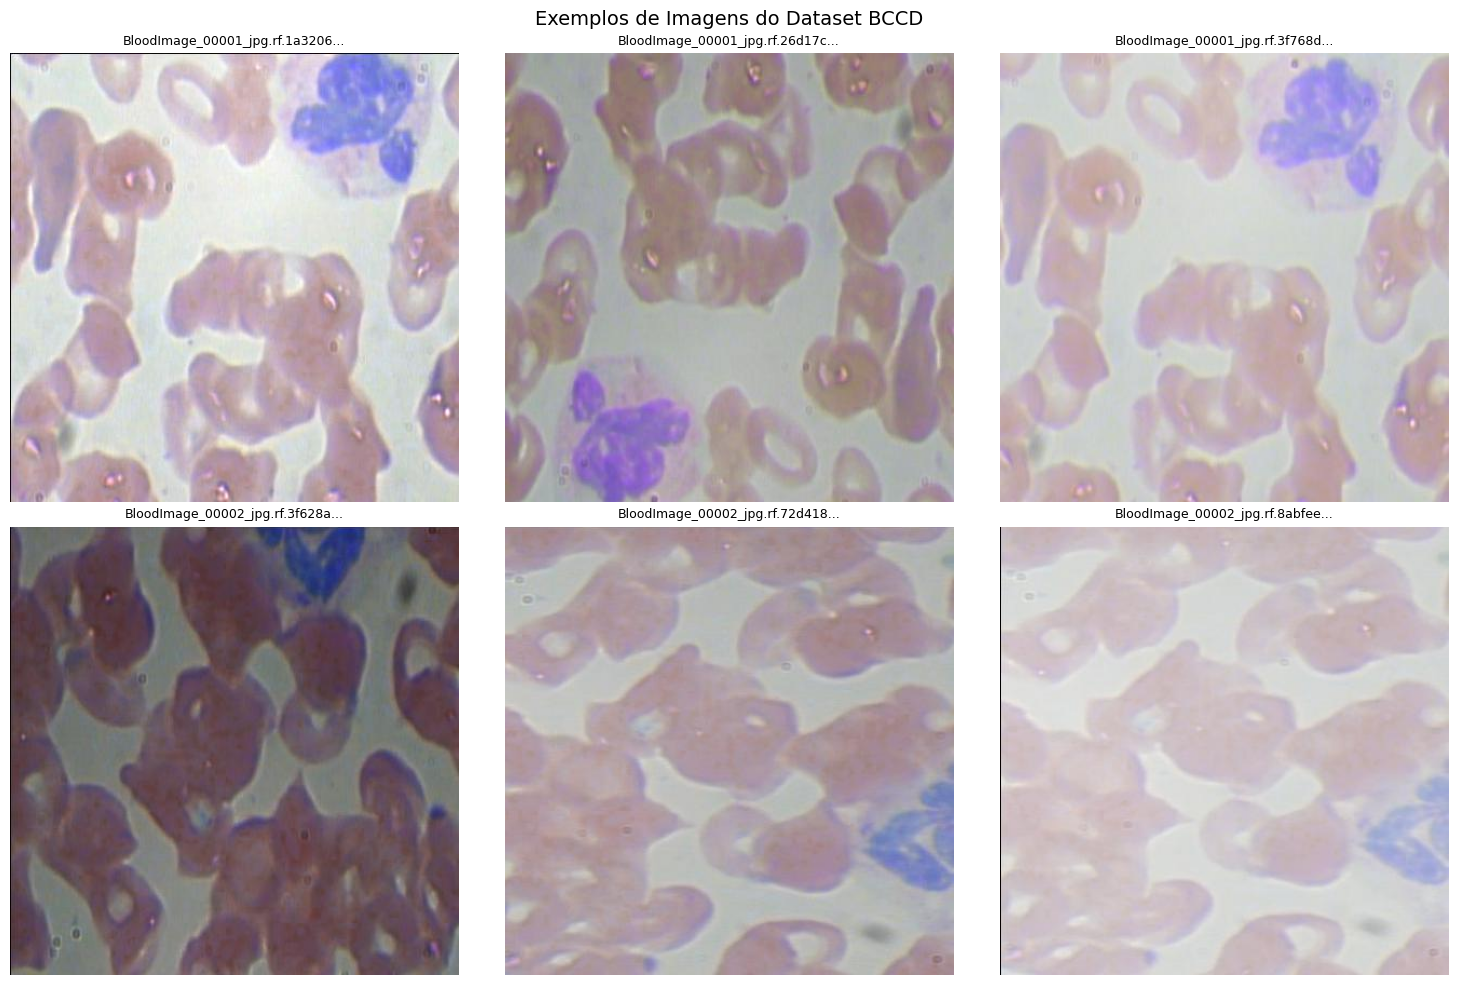

In [12]:
# Carregar algumas imagens de exemplo
images = load_bccd_images('bccd_images/train', max_images=6)
print(f"Carregadas {len(images)} imagens.")

# Mostrar exemplos
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for idx, (filepath, img) in enumerate(images):
    ax = axes[idx // 3, idx % 3]
    ax.imshow(img)
    ax.set_title(os.path.basename(filepath)[:30] + '...', fontsize=9)
    ax.axis('off')
plt.suptitle('Exemplos de Imagens do Dataset BCCD', fontsize=14)
plt.tight_layout()
plt.show()

Anotacoes encontradas: 19 objetos
Contagem: {'WBC': 1, 'RBC': 18}


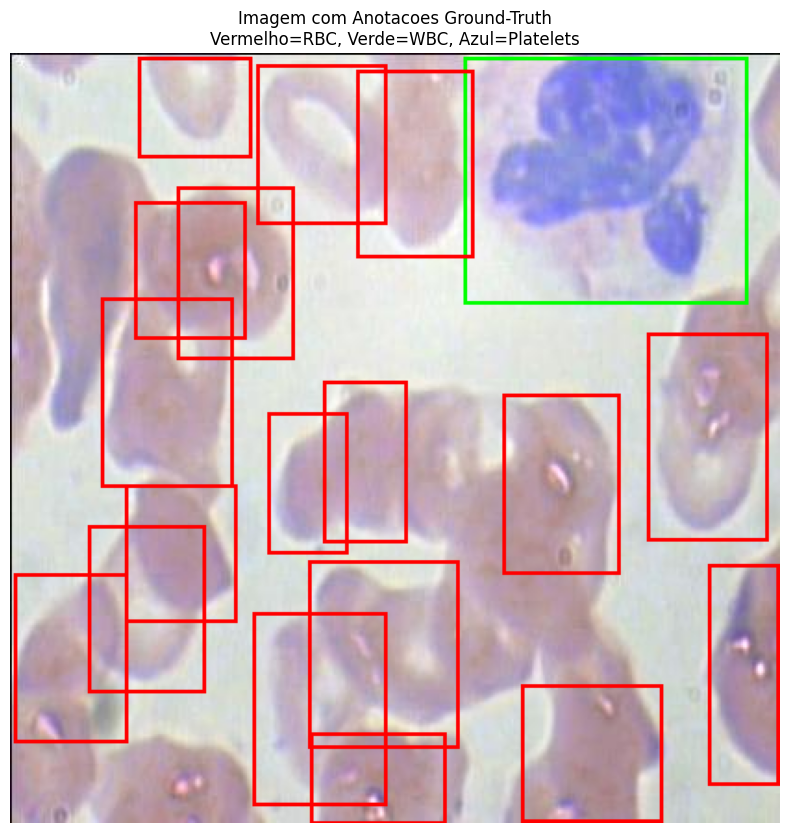

In [13]:
# Carregar e visualizar anotacoes de uma imagem
test_img_path = images[0][0]
test_xml_path = test_img_path.replace('.jpg', '.xml')

if os.path.exists(test_xml_path):
    annotations = parse_voc_xml(test_xml_path)
    print(f"Anotacoes encontradas: {len(annotations)} objetos")
    
    # Contar por tipo
    counts = {}
    for obj in annotations:
        name = obj['name']
        counts[name] = counts.get(name, 0) + 1
    print(f"Contagem: {counts}")
    
    # Visualizar com anotacoes
    img = images[0][1].copy()
    
    colors = {'RBC': (255, 0, 0), 'WBC': (0, 255, 0), 'Platelets': (0, 0, 255)}
    
    for obj in annotations:
        xmin, ymin, xmax, ymax = obj['bbox']
        color = colors.get(obj['name'], (255, 255, 0))
        img = draw_rectangles(img, [(xmin, ymin, xmax, ymax)], color=color, thickness=2)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title('Imagem com Anotacoes Ground-Truth\nVermelho=RBC, Verde=WBC, Azul=Platelets')
    plt.axis('off')
    plt.show()
else:
    print(f"Arquivo XML nao encontrado: {test_xml_path}")

---
## 4. Pre-processamento da Imagem

In [14]:
# Selecionar uma imagem para processamento
_, test_img = images[0]

print(f"Dimensoes da imagem: {test_img.shape}")
print(f"Tipo de dados: {test_img.dtype}")
print(f"Valores min/max: {test_img.min()} / {test_img.max()}")

Dimensoes da imagem: (416, 416, 3)
Tipo de dados: uint8
Valores min/max: 0 / 255


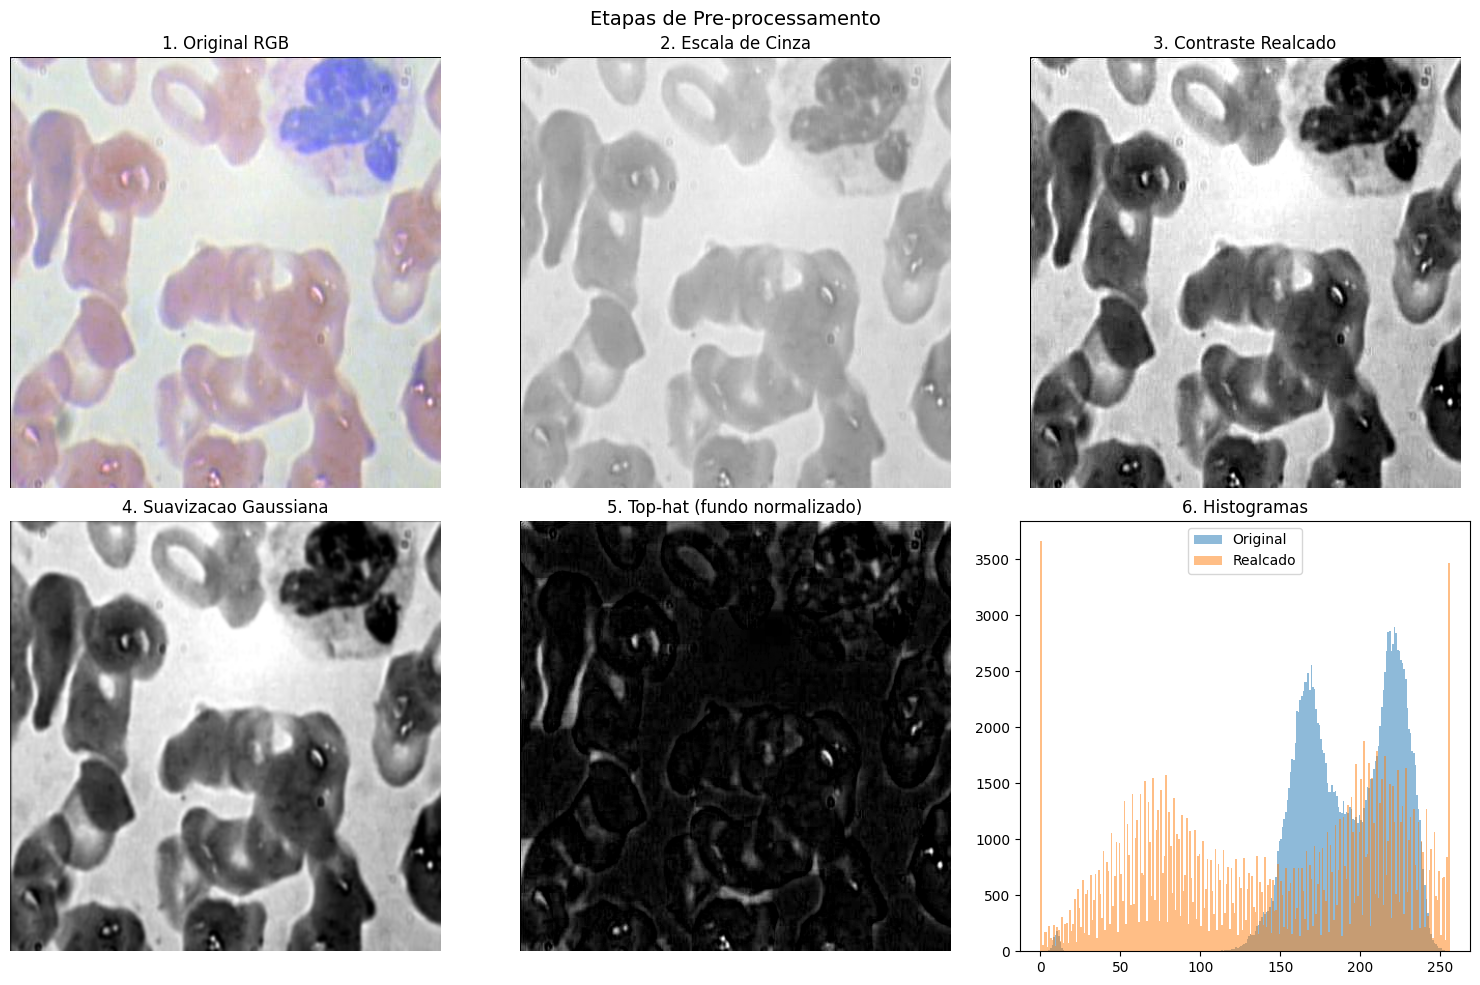

In [15]:
# 4.1 Conversao para escala de cinza
gray = rgb2gray(test_img)

# 4.2 Realce de contraste
gray_enhanced = histogram_stretch(gray)

# 4.3 Suavizacao Gaussiana
gray_smooth = gaussian_blur(gray_enhanced, size=5, sigma=1.0)

# 4.4 Top-hat para normalizacao de fundo
gray_tophat = tophat(gray_enhanced, SE_size=15)

# Visualizar etapas de pre-processamento
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(test_img)
axes[0, 0].set_title('1. Original RGB')
axes[0, 0].axis('off')

axes[0, 1].imshow(gray, cmap='gray')
axes[0, 1].set_title('2. Escala de Cinza')
axes[0, 1].axis('off')

axes[0, 2].imshow(gray_enhanced, cmap='gray')
axes[0, 2].set_title('3. Contraste Realcado')
axes[0, 2].axis('off')

axes[1, 0].imshow(gray_smooth, cmap='gray')
axes[1, 0].set_title('4. Suavizacao Gaussiana')
axes[1, 0].axis('off')

axes[1, 1].imshow(gray_tophat, cmap='gray')
axes[1, 1].set_title('5. Top-hat (fundo normalizado)')
axes[1, 1].axis('off')

# Histograma
axes[1, 2].hist(gray.flatten(), bins=256, range=(0, 256), alpha=0.5, label='Original')
axes[1, 2].hist(gray_enhanced.flatten(), bins=256, range=(0, 256), alpha=0.5, label='Realcado')
axes[1, 2].set_title('6. Histogramas')
axes[1, 2].legend()

plt.suptitle('Etapas de Pre-processamento', fontsize=14)
plt.tight_layout()
plt.show()

---
## 5. Deteccao de RBCs (Eritrocitos) usando Transformada de Hough Circular

In [16]:
# Parametros para deteccao de RBCs
# RBCs tem diametro tipico de 60-80 pixels nas imagens 416x416
# Raio estimado: 30-40 pixels
# Parametros calibrados em 3 imagens do dataset (GT=18 RBCs cada)

RBC_R_MIN = 25
RBC_R_MAX = 45
RBC_THRESHOLD_EDGE = 35
RBC_THRESHOLD_ACC = 60  # Ajustado para reduzir falsos positivos
RBC_MIN_DIST = 40

print("Parametros para deteccao de RBCs:")
print(f"  Raio minimo: {RBC_R_MIN}")
print(f"  Raio maximo: {RBC_R_MAX}")
print(f"  Threshold de borda: {RBC_THRESHOLD_EDGE}")
print(f"  Threshold do acumulador: {RBC_THRESHOLD_ACC}")
print(f"  Distancia minima entre centros: {RBC_MIN_DIST}")

Parametros para deteccao de RBCs:
  Raio minimo: 25
  Raio maximo: 45
  Threshold de borda: 35
  Threshold do acumulador: 60
  Distancia minima entre centros: 40


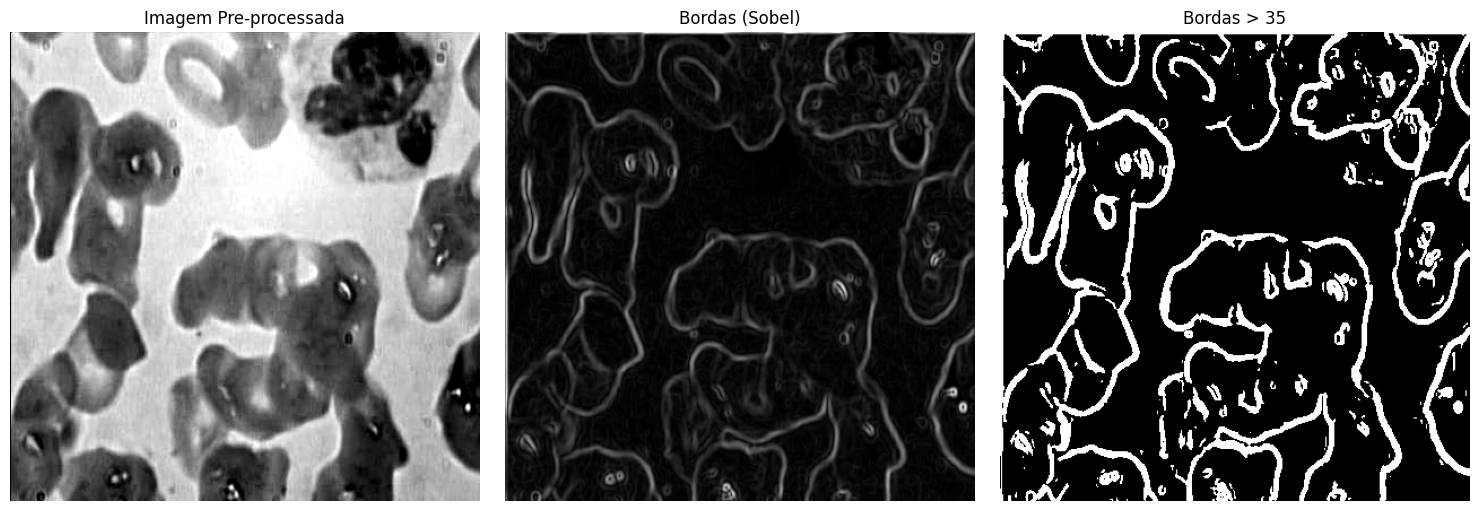

In [17]:
# Detectar bordas para visualizacao
edges = sobel_edges(gray_enhanced, blur_first=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(gray_enhanced, cmap='gray')
axes[0].set_title('Imagem Pre-processada')
axes[0].axis('off')

axes[1].imshow(edges, cmap='gray')
axes[1].set_title('Bordas (Sobel)')
axes[1].axis('off')

axes[2].imshow(edges > RBC_THRESHOLD_EDGE, cmap='gray')
axes[2].set_title(f'Bordas > {RBC_THRESHOLD_EDGE}')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [18]:
# Detectar circulos (RBCs)
print("Detectando RBCs com Transformada de Hough Circular...")
print("(Isso pode demorar alguns segundos)")

rbc_circles = detect_circles_hough(
    gray_enhanced,
    r_min=RBC_R_MIN,
    r_max=RBC_R_MAX,
    threshold_edge=RBC_THRESHOLD_EDGE,
    threshold_acc=RBC_THRESHOLD_ACC,
    min_dist=RBC_MIN_DIST
)

print(f"\nRBCs detectados: {len(rbc_circles)}")

Detectando RBCs com Transformada de Hough Circular...
(Isso pode demorar alguns segundos)

RBCs detectados: 0


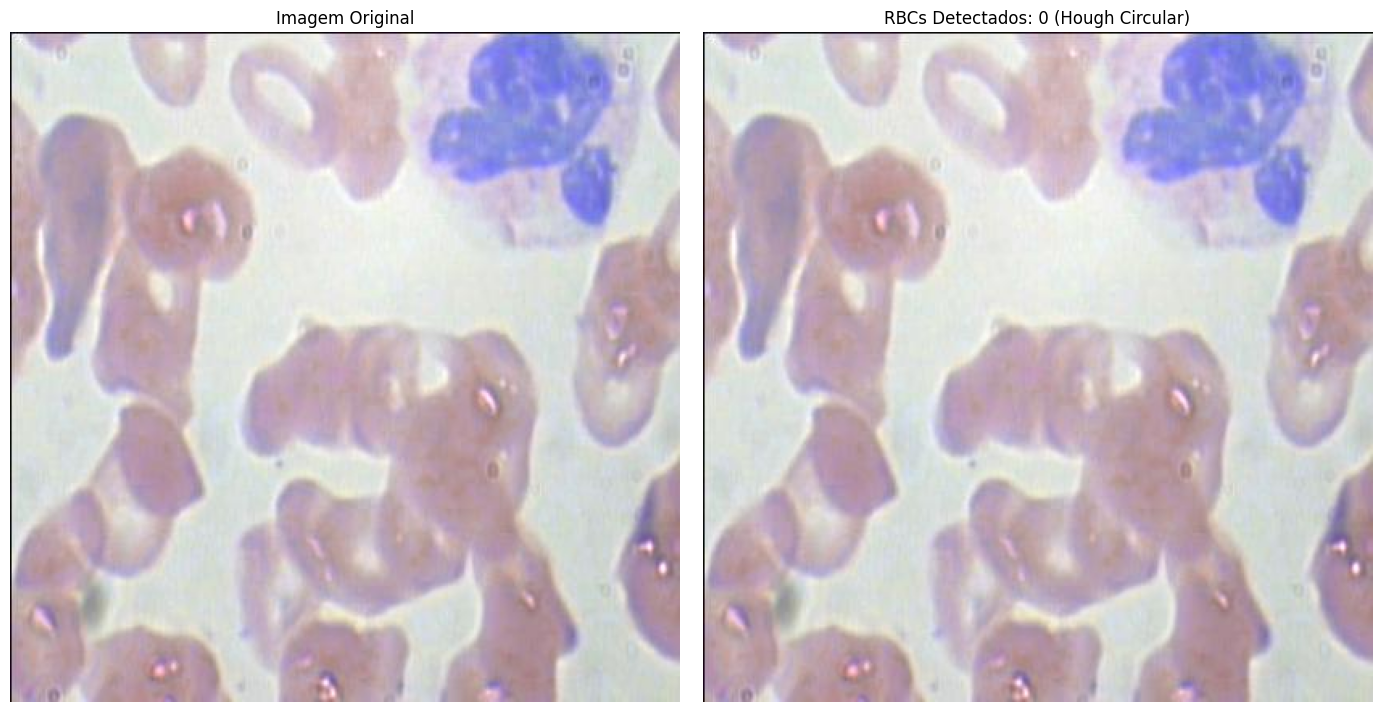

In [19]:
# Visualizar RBCs detectados
img_with_rbcs = draw_circles(test_img, rbc_circles, color=(255, 0, 0), thickness=2)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(test_img)
axes[0].set_title('Imagem Original')
axes[0].axis('off')

axes[1].imshow(img_with_rbcs)
axes[1].set_title(f'RBCs Detectados: {len(rbc_circles)} (Hough Circular)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

---
## 6. Deteccao de WBCs (Leucocitos) usando Segmentacao por Cor e Morfologia

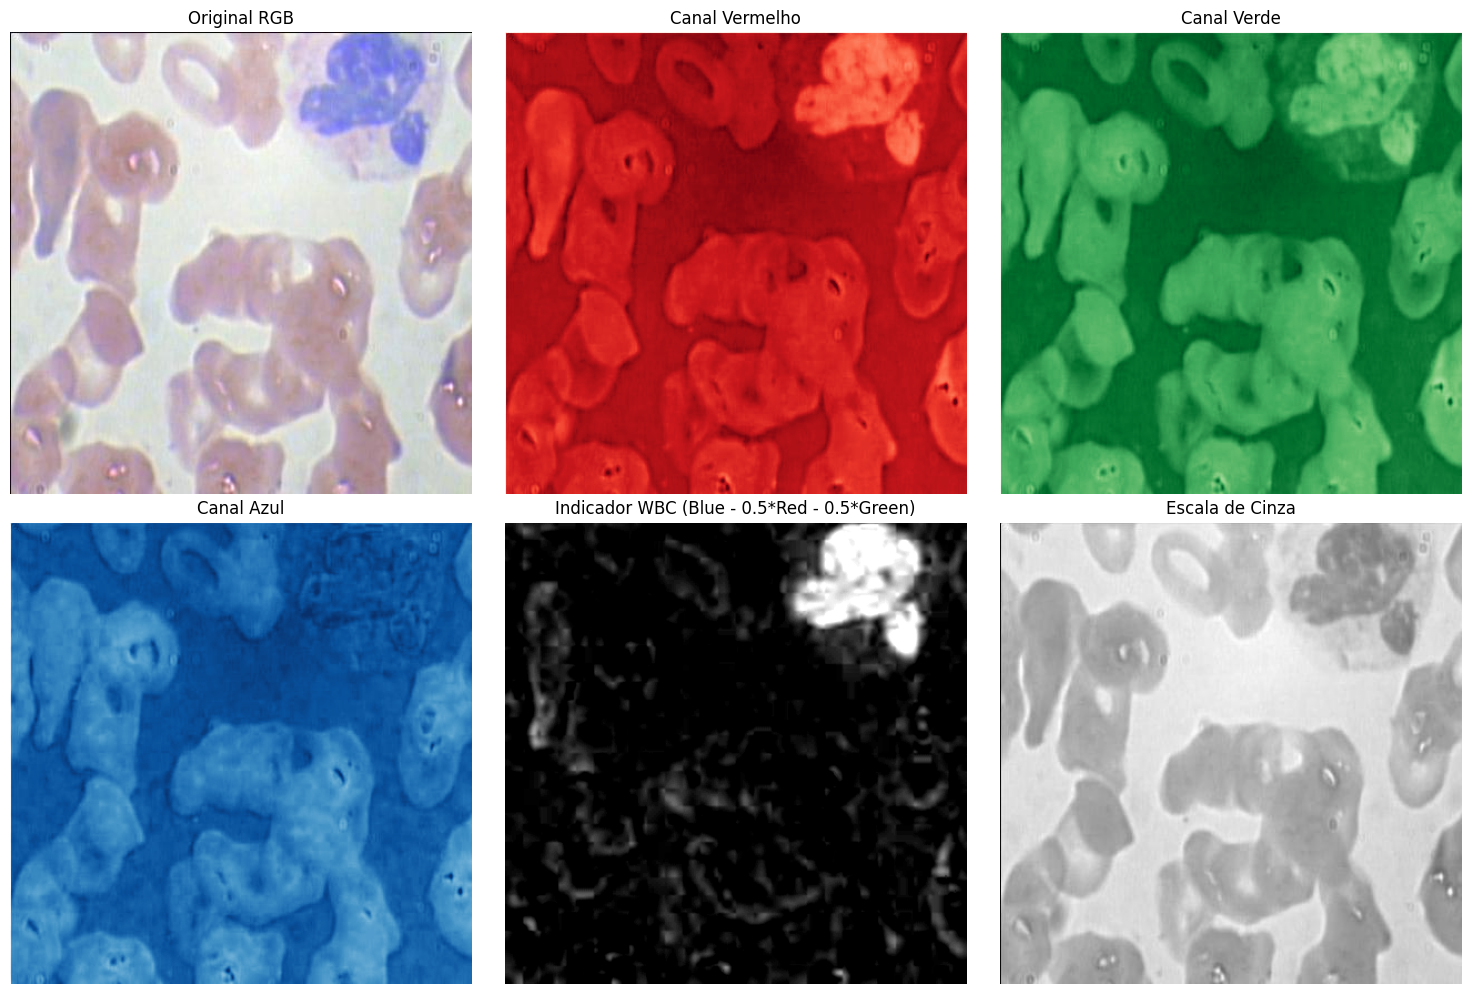

In [20]:
# WBCs tem nucleo escuro/roxo que pode ser detectado pelo canal azul
# Estrategia: Segmentar regioes escuras grandes

# Extrair canal azul (onde o nucleo do WBC e mais visivel)
blue_channel = test_img[:, :, 2].astype(np.float64)
red_channel = test_img[:, :, 0].astype(np.float64)
green_channel = test_img[:, :, 1].astype(np.float64)

# Ratio: regiao roxa tem mais azul em relacao ao vermelho
# WBCs aparecem mais escuros na escala de cinza mas tem nucleo roxo/azulado
wbc_indicator = blue_channel - 0.5 * red_channel - 0.5 * green_channel
wbc_indicator = np.clip(wbc_indicator, 0, 255)

# Realce
wbc_indicator = histogram_stretch(wbc_indicator)

# Visualizar canais
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(test_img)
axes[0, 0].set_title('Original RGB')
axes[0, 0].axis('off')

axes[0, 1].imshow(red_channel, cmap='Reds')
axes[0, 1].set_title('Canal Vermelho')
axes[0, 1].axis('off')

axes[0, 2].imshow(green_channel, cmap='Greens')
axes[0, 2].set_title('Canal Verde')
axes[0, 2].axis('off')

axes[1, 0].imshow(blue_channel, cmap='Blues')
axes[1, 0].set_title('Canal Azul')
axes[1, 0].axis('off')

axes[1, 1].imshow(wbc_indicator, cmap='gray')
axes[1, 1].set_title('Indicador WBC (Blue - 0.5*Red - 0.5*Green)')
axes[1, 1].axis('off')

axes[1, 2].imshow(gray, cmap='gray')
axes[1, 2].set_title('Escala de Cinza')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [22]:
# Deteccao de WBC usando regiao escura (nucleo)
# WBCs tem nucleo escuro na escala de cinza

# Usar bottom-hat para destacar regioes escuras
dark_regions = bottomhat(gray_enhanced, SE_size=25)

# Binarizar
wbc_binary, wbc_thresh = binarize(dark_regions.astype(np.uint8))
print(f"Threshold usado para WBC: {wbc_thresh}")

# Operacoes morfologicas para limpar
SE = np.ones((3, 3), dtype=np.uint8)
wbc_binary = opening_binary(wbc_binary, SE)  # Remove ruido
wbc_binary = closing_binary(wbc_binary, SE)  # Preenche buracos

# Dilatar para conectar regioes
SE_large = np.ones((5, 5), dtype=np.uint8)
wbc_binary = dilation_binary(wbc_binary, SE_large)
wbc_binary = dilation_binary(wbc_binary, SE_large)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(dark_regions, cmap='gray')
plt.title('Bottom-hat (regioes escuras)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(wbc_binary, cmap='gray')
plt.title('Binarizado + Morfologia')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(test_img)
plt.imshow(wbc_binary, alpha=0.3, cmap='Reds')
plt.title('Sobreposicao')
plt.axis('off')

plt.tight_layout()
plt.show()

Threshold usado para WBC: 54


IndexError: index 9 is out of bounds for axis 0 with size 9

WBCs detectados: 0


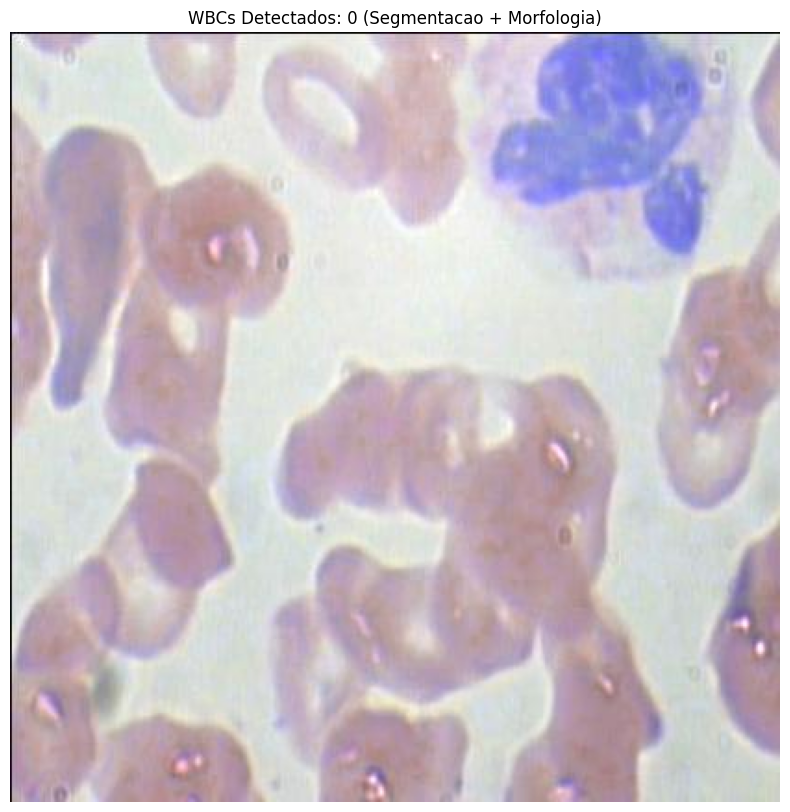

In [23]:
# Encontrar componentes conexas e filtrar por tamanho
WBC_AREA_MIN = 3000  # Area minima para ser considerado WBC
WBC_AREA_MAX = 25000  # Area maxima

labeled = label(wbc_binary)
regions = regionprops(labeled)

wbc_detections = []
for region in regions:
    if WBC_AREA_MIN < region.area < WBC_AREA_MAX:
        minr, minc, maxr, maxc = region.bbox
        wbc_detections.append((minc, minr, maxc, maxr))  # (xmin, ymin, xmax, ymax)

print(f"WBCs detectados: {len(wbc_detections)}")

# Visualizar
img_with_wbcs = draw_rectangles(test_img, wbc_detections, color=(0, 255, 0), thickness=3)

plt.figure(figsize=(10, 10))
plt.imshow(img_with_wbcs)
plt.title(f'WBCs Detectados: {len(wbc_detections)} (Segmentacao + Morfologia)')
plt.axis('off')
plt.show()

---
## 7. Deteccao de Plaquetas usando Analise de Tamanho

In [24]:
# Plaquetas sao objetos muito pequenos e escuros
# Estrategia: Detectar objetos pequenos que nao sao RBCs nem WBCs

# Usar deteccao de bordas e limiarizacao
edges_enhanced = sobel_edges(gray_enhanced, blur_first=True)

# Limiarizar bordas
platelet_thresh = 25
edge_binary = (edges_enhanced > platelet_thresh).astype(np.uint8)

# Dilatar para conectar bordas
SE_small = np.ones((3, 3), dtype=np.uint8)
edge_dilated = dilation_binary(edge_binary, SE_small)

# Encontrar componentes conexas
labeled_edges = label(edge_dilated)
edge_regions = regionprops(labeled_edges)

# Filtrar por tamanho (plaquetas sao muito pequenas)
PLATELET_AREA_MIN = 50
PLATELET_AREA_MAX = 800

platelet_detections = []
for region in edge_regions:
    if PLATELET_AREA_MIN < region.area < PLATELET_AREA_MAX:
        # Verificar se nao esta dentro de um RBC ou WBC detectado
        cy, cx = region.centroid
        is_inside_rbc = False
        is_inside_wbc = False
        
        # Verificar RBCs
        for (rx, ry, rr, _) in rbc_circles:
            dist = np.sqrt((cx - rx)**2 + (cy - ry)**2)
            if dist < rr:
                is_inside_rbc = True
                break
        
        # Verificar WBCs
        for (xmin, ymin, xmax, ymax) in wbc_detections:
            if xmin <= cx <= xmax and ymin <= cy <= ymax:
                is_inside_wbc = True
                break
        
        if not is_inside_rbc and not is_inside_wbc:
            minr, minc, maxr, maxc = region.bbox
            platelet_detections.append((minc, minr, maxc, maxr))

print(f"Plaquetas detectadas: {len(platelet_detections)}")

Plaquetas detectadas: 19


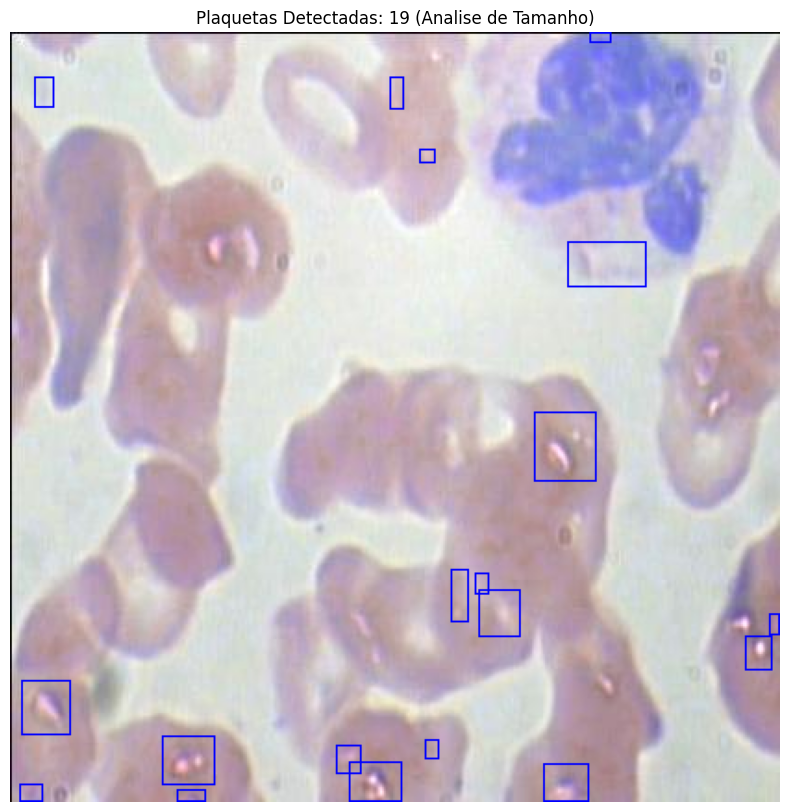

In [25]:
# Visualizar plaquetas
img_with_platelets = draw_rectangles(test_img, platelet_detections, color=(0, 0, 255), thickness=1)

plt.figure(figsize=(10, 10))
plt.imshow(img_with_platelets)
plt.title(f'Plaquetas Detectadas: {len(platelet_detections)} (Analise de Tamanho)')
plt.axis('off')
plt.show()

---
## 8. Resultado Final: Todas as Deteccoes Combinadas

In [26]:
# Combinar todas as deteccoes em uma unica visualizacao

def detect_all_cells(img):
    """
    Funcao principal que detecta todas as celulas em uma imagem.
    Retorna contagens e imagem com deteccoes.
    """
    # Pre-processamento
    gray = rgb2gray(img)
    gray_enhanced = histogram_stretch(gray)
    
    # ===== DETECCAO DE RBCs =====
    rbc_circles = detect_circles_hough(
        gray_enhanced,
        r_min=25, r_max=45,
        threshold_edge=35,
        threshold_acc=60,  # Ajustado para reduzir falsos positivos
        min_dist=40
    )
    
    # ===== DETECCAO DE WBCs =====
    dark_regions = bottomhat(gray_enhanced, SE_size=25)
    wbc_binary, _ = binarize(dark_regions.astype(np.uint8))
    SE = np.ones((3, 3), dtype=np.uint8)
    wbc_binary = opening_binary(wbc_binary, SE)
    wbc_binary = closing_binary(wbc_binary, SE)
    SE_large = np.ones((5, 5), dtype=np.uint8)
    wbc_binary = dilation_binary(wbc_binary, SE_large)
    wbc_binary = dilation_binary(wbc_binary, SE_large)
    
    labeled = label(wbc_binary)
    regions = regionprops(labeled)
    
    wbc_detections = []
    for region in regions:
        if 3000 < region.area < 25000:
            minr, minc, maxr, maxc = region.bbox
            wbc_detections.append((minc, minr, maxc, maxr))
    
    # ===== DETECCAO DE PLAQUETAS =====
    edges = sobel_edges(gray_enhanced, blur_first=True)
    edge_binary = (edges > 25).astype(np.uint8)
    SE_small = np.ones((3, 3), dtype=np.uint8)
    edge_dilated = dilation_binary(edge_binary, SE_small)
    
    labeled_edges = label(edge_dilated)
    edge_regions = regionprops(labeled_edges)
    
    platelet_detections = []
    for region in edge_regions:
        if 50 < region.area < 800:
            cy, cx = region.centroid
            is_inside = False
            
            for (rx, ry, rr, _) in rbc_circles:
                if np.sqrt((cx - rx)**2 + (cy - ry)**2) < rr:
                    is_inside = True
                    break
            
            for (xmin, ymin, xmax, ymax) in wbc_detections:
                if xmin <= cx <= xmax and ymin <= cy <= ymax:
                    is_inside = True
                    break
            
            if not is_inside:
                minr, minc, maxr, maxc = region.bbox
                platelet_detections.append((minc, minr, maxc, maxr))
    
    # ===== DESENHAR RESULTADOS =====
    result_img = img.copy()
    result_img = draw_circles(result_img, rbc_circles, color=(255, 0, 0), thickness=2)
    result_img = draw_rectangles(result_img, wbc_detections, color=(0, 255, 0), thickness=3)
    result_img = draw_rectangles(result_img, platelet_detections, color=(0, 0, 255), thickness=1)
    
    counts = {
        'RBC': len(rbc_circles),
        'WBC': len(wbc_detections),
        'Platelets': len(platelet_detections)
    }
    
    return result_img, counts, rbc_circles, wbc_detections, platelet_detections

print("Funcao detect_all_cells definida.")

Funcao detect_all_cells definida.


In [27]:
# Processar imagem de teste
print("Processando imagem...")
result_img, counts, rbc_list, wbc_list, platelet_list = detect_all_cells(test_img)

print("\n" + "="*50)
print("RESULTADO DA DETECCAO")
print("="*50)
print(f"RBCs (eritrocitos):    {counts['RBC']}")
print(f"WBCs (leucocitos):     {counts['WBC']}")
print(f"Plaquetas:             {counts['Platelets']}")
print(f"Total de celulas:      {sum(counts.values())}")
print("="*50)

Processando imagem...


IndexError: index 9 is out of bounds for axis 0 with size 9

NameError: name 'result_img' is not defined

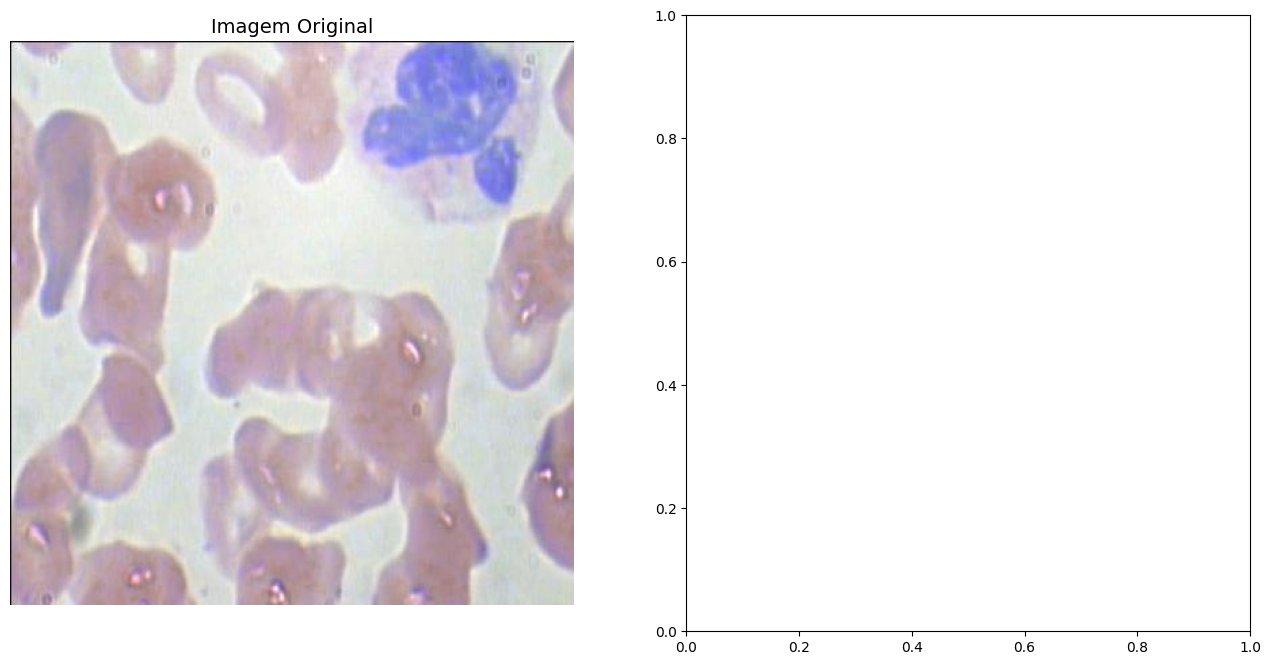

In [28]:
# Visualizacao final
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(test_img)
axes[0].set_title('Imagem Original', fontsize=14)
axes[0].axis('off')

axes[1].imshow(result_img)
axes[1].set_title(f'Deteccao de Celulas Sanguineas\n'
                  f'RBC (vermelho): {counts["RBC"]} | '
                  f'WBC (verde): {counts["WBC"]} | '
                  f'Plaquetas (azul): {counts["Platelets"]}', fontsize=12)
axes[1].axis('off')

plt.suptitle('Deteccao de Celulas Sanguineas usando Tecnicas Tradicionais de PI', fontsize=16)
plt.tight_layout()
plt.savefig('bccd_detection_result.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nResultado salvo em: bccd_detection_result.png")

---
## 9. Teste em Multiplas Imagens

In [ ]:
# Processar multiplas imagens
print("Processando multiplas imagens...\n")

results = []
for filepath, img in images[:6]:
    result_img, counts, _, _, _ = detect_all_cells(img)
    results.append((filepath, img, result_img, counts))
    print(f"{os.path.basename(filepath)[:40]}: RBC={counts['RBC']}, WBC={counts['WBC']}, Platelets={counts['Platelets']}")

In [ ]:
# Visualizar resultados em grade
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, (filepath, orig_img, result_img, counts) in enumerate(results):
    ax = axes[idx // 3, idx % 3]
    ax.imshow(result_img)
    ax.set_title(f'RBC: {counts["RBC"]} | WBC: {counts["WBC"]} | Plt: {counts["Platelets"]}', fontsize=10)
    ax.axis('off')

plt.suptitle('Deteccao de Celulas em Multiplas Imagens BCCD', fontsize=16)
plt.tight_layout()
plt.savefig('bccd_multiple_results.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 10. Conclusoes

### Tecnicas Tradicionais de Processamento de Imagem Utilizadas:

1. **Conversao RGB para Escala de Cinza**: Formula de luminancia (Y = 0.299R + 0.587G + 0.114B)

2. **Realce de Contraste**: Stretch de histograma usando percentis

3. **Suavizacao**: Filtro Gaussiano para reducao de ruido

4. **Deteccao de Bordas**: Filtro de Sobel (gradiente de magnitude)

5. **Transformada de Hough Circular (CHT)**: Para deteccao de RBCs (formato circular)

6. **Operacoes Morfologicas**:
   - Erosao e Dilatacao (binaria e em escala de cinza)
   - Abertura e Fechamento
   - Top-hat e Bottom-hat

7. **Limiarizacao**: Metodo de Otsu para binarizacao automatica

8. **Analise de Componentes Conexas**: Para segmentacao e contagem de objetos

### Limitacoes:

- Dificuldade em detectar celulas sobrepostas
- Sensibilidade a variacao de iluminacao
- Plaquetas sao dificeis de detectar devido ao tamanho pequeno
- Parametros precisam ser ajustados manualmente para diferentes imagens

### Possiveis Melhorias (sem usar ML):

- Usar espaco de cor HSV para melhor separacao de WBCs
- Implementar watershed para separar celulas sobrepostas
- Ajuste adaptativo de parametros baseado em estatisticas da imagem